# Using Current Data To Make Recommendations
### Model #1: (Classification - Fully Paid vs. Default) 
### Model #2: ( Regression - Annualized Return %)

In [1]:
import pandas as pd
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
from functions_and_objects import (impute_means_zeros_maxs_X,parse_percentage,
                                   clean_new_LC_data_classification_current,clean_LC_data_classification_eval,
                                   preprocessing_current, preprocessing_future_test, columns_list, 
                                   nan_max_cols, nan_mean_cols, nan_zero_cols, dtype,
                                   one_hot_encode_current, concat_X_and_6ohe_dfs,
                                   prep_all_df_for_classification, 
                                   view_columns_by_number_of_rows_that_have_nan,
                                   current_pipeline, str_to_float_cols)
from functions_and_objects import (prep_df_for_regression_current,
                                   calc_annu_return,impute_annu_return_to_y,
                                   scale_current)

import joblib
from sklearn.metrics import (accuracy_score, precision_score, recall_score, #classification
                             f1_score, roc_auc_score, roc_curve,precision_recall_fscore_support, #classification
                             r2_score,mean_squared_error) #regression
from sklearn.preprocessing import StandardScaler
%load_ext autoreload
%autoreload 2

### Import New Data from 7.29.19

In [2]:
browseNotes = pd.read_csv('~/Downloads/primaryMarketNotes_browseNotes_1-RETAIL (1).csv')
browseNotes.head()

,id,member_id,loan_amnt,funded_amnt,term,int_rate,exp_default_rate,service_fee_rate,installment,grade,...,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog
0,153931982,189430758,21275.0,15675.0,36,17.97,12.63,1.49,768.83,D,...,11-19-1996 16:00:00,0,2,6,8.8,1,15,0,0,57
1,155519531,192519120,29225.0,27250.0,36,12.40,5.14,1.03,976.29,B,...,03-16-1992 16:00:00,0,6,29,77.5,11,24,0,0,
2,155397480,192188577,10000.0,5475.0,36,15.24,7.92,1.22,347.83,C,...,04-15-2013 17:00:00,3,0,4,27.2,1,5,0,0,43
3,154980225,191419066,40000.0,19100.0,60,10.33,5.48,0.75,856.40,B,...,03-08-2000 16:00:00,0,1,14,39.7,4,11,0,0,
4,155911399,193058111,10000.0,9750.0,36,11.71,5.14,1.03,330.76,B,...,,,,,,,,,,


In [3]:
dfs_list = [browseNotes]

In [4]:
browseNotes.shape

(83, 122)

In [5]:
browseNotes['all_util'][80]

' '

In [6]:
browseNotes['revol_util'][17]

' '

### Load DF from Pipeline

In [7]:
(X_current_regr, y_current, table_all_current) = current_pipeline(dfs_list, '../nn_v8.joblib', '../rf_regr_v5.joblib')

/Users/flatironschool/Desktop/flatiron/blogs_and_projects/peervest/notebooks_functions/functions_and_objects.py:417: FutureWarning: Passing datetime64-dtype data to TimedeltaIndex is deprecated, will raise a TypeError in a future version
  raw_lc_df['earliest_cr_line'] = pd.to_timedelta(pd.to_datetime(raw_lc_df['earliest_cr_line'])).dt.days


[]


Using TensorFlow backend.
W0729 15:13:15.754330 4549371328 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0729 15:13:15.801815 4549371328 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0729 15:13:15.952436 4549371328 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0729 15:13:15.953299 4549371328 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0729 15:13:15.954099 4549371328 depr

In [8]:
len(y_current[(y_current['prob_default'] < 1) & (y_current['return_preds'] > -.1)])

67

/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


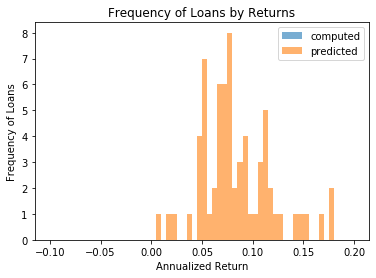

In [9]:
plt.hist(table_all_current['annu_return'],bins=60,range=(-0.1,0.2),label='computed',alpha=0.6)
plt.hist(table_all_current['return_preds'],bins=60,range=(-0.1,0.2),label='predicted',alpha=0.6)
plt.xlabel('Annualized Return')
plt.ylabel('Frequency of Loans')
plt.legend()
plt.title('Frequency of Loans by Returns')
plt.show()

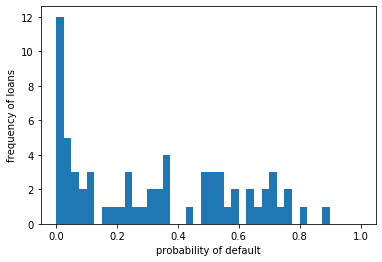

In [10]:
plt.hist(table_all_current['prob_default'],bins=40, range=(0,1))
plt.xlabel('probability of default')
plt.ylabel('frequency of loans')
plt.show()

In [11]:
table_all_current.drop(columns=['annu_return'],inplace=True)

In [12]:
table_all_current

,prob_default,prob_fullypaid,return_preds,loan_amnt,funded_amnt,int_rate,emp_length,annual_inc,dti,delinq_2yrs,...,emp_title_2_Technician,emp_title_2_Truck Driver,emp_title_2_Vice President,emp_title_2_driver,emp_title_2_manager,emp_title_2_owner,emp_title_2_sales,emp_title_2_supervisor,emp_title_2_teacher,emp_title_2_truck driver
id,,,,,,,,,,,,,,,,,,,,,
155397480,0.723799,0.276201,0.078435,10000,5475.0,0.1524,1.0,21320.0,28.01,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
154980225,0.005614,0.994386,0.065921,40000,19100.0,0.1033,1.0,170000.0,4.06,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
155263777,0.095000,0.905000,0.055861,25000,9350.0,0.1240,1.0,50000.0,36.49,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
155525071,0.597686,0.402314,0.123991,30000,23325.0,0.1797,1.0,55000.0,18.97,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
154672329,0.350160,0.649840,0.125086,40000,33950.0,0.1797,1.0,70000.0,34.66,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
155524857,0.194894,0.805106,0.065351,31000,22200.0,0.1033,1.0,56000.0,13.67,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
155885924,0.006219,0.993781,0.053642,5400,4200.0,0.0819,1.0,80000.0,5.72,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
155466042,0.031727,0.968273,0.095554,34025,14950.0,0.1430,1.0,45000.0,32.99,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
155824525,0.318403,0.681597,0.053730,16000,15100.0,0.0881,1.0,28000.0,30.69,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
table_all_current.to_pickle('table_all_current_7.29.19.pkl')